<a href="https://colab.research.google.com/github/UW-ERSL/TOuNN/blob/main/TOuNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # run this first time to clone the directory 
# !git clone https://github.com/UW-ERSL/TOuNN.git
# %cd TOuNN/

### Imports

In [2]:
import numpy as np
import time
# from TOuNNOptimizer import TopologyOptimizer
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.optim as optim
from os import path

from tounn.FE import FE
from tounn.plotUtil import Plotter
from tounn.network import TopNet

import matplotlib.pyplot as plt
from torch.autograd import grad

### Mesh 

In [3]:
nely = 101;
nelx = nely*3; 

elemSize = np.array([1.0, 1.0]);
mesh = {'nelx':nelx, 'nely':nely, 'elemSize':elemSize};

### Material

In [4]:
matProp = {'E':1.0, 'nu':0.3}; # Structural
matProp['penal'] = 3.; # SIMP penalization constant, starting value

### Boundary Condition

In [5]:
exampleName = 'TipCantilever'
physics = 'Structural'
ndof = 2*(nelx+1)*(nely+1);
force = np.zeros((ndof,1))
dofs=np.arange(ndof);
fixed = dofs[0:2*(nely+1):1];
force[2*(nelx+1)*(nely+1)-2*nely+1, 0 ] = -1;
symXAxis = {'isOn':False, 'midPt':0.5*nely};
symYAxis = {'isOn':False, 'midPt':0.5*nelx};
bc = {'exampleName':exampleName, 'physics':physics, \
      'force':force, 'fixed':fixed, 'symXAxis':symXAxis, 'symYAxis':symYAxis };

# For more BCs see examples.py

### NN Settings

In [6]:
nnSettings = {'numLayers':3, 'numNeuronsPerLyr':20}

### Constraints and Projections

In [7]:
densityProjection = {'isOn':True, 'sharpness':8};
desiredVolumeFraction = 0.3;

### Optimizer settings

In [8]:
minEpochs = 150; # minimum number of iterations
maxEpochs = 5000; # Max number of iterations

In [9]:
class TopologyOptimizer:
    def __init__(self, mesh, matProp, bc, nnSettings, \
                  desiredVolumeFraction, densityProjection, overrideGPU = True):

        self.exampleName = bc['exampleName'];
        self.device = self.setDevice(overrideGPU);
        self.boundaryResolution  = 3; # default value for plotting and interpreting
        self.FE = FE(mesh, matProp, bc);
        self.xy = torch.tensor(self.FE.elemCenters, requires_grad = True).\
                                        float().view(-1,2).to(self.device);
        self.xyPlot = torch.tensor(self.FE.generatePoints(self.boundaryResolution, True),\
                        requires_grad = True).float().view(-1,2).to(self.device);
        self.Pltr = Plotter();

        self.desiredVolumeFraction = desiredVolumeFraction;
        self.density = self.desiredVolumeFraction*np.ones((self.FE.numElems));
        self.symXAxis = bc['symXAxis'];
        self.symYAxis = bc['symYAxis'];

        self.densityProjection = densityProjection;

        inputDim = 2; # x and y coordn
        self.topNet = TopNet(nnSettings, inputDim).to(self.device);
        self.objective = 0.;

    def setDevice(self, overrideGPU):
        if(torch.cuda.is_available() and (overrideGPU == False) ):
            device = torch.device("cuda:0");
            print("GPU enabled")
        else:
            device = torch.device("cpu")
            print("Running on CPU")
        return device;

    def applySymmetry(self, x):
        if(self.symYAxis['isOn']):
            xv =( self.symYAxis['midPt'] + torch.abs( x[:,0] - self.symYAxis['midPt']));
        else:
            xv = x[:,0];
        if(self.symXAxis['isOn']):
            yv = (self.symXAxis['midPt'] + torch.abs( x[:,1] - self.symXAxis['midPt'])) ;
        else:
            yv = x[:,1];
        x = torch.transpose(torch.stack((xv,yv)),0,1);
        return x;

    def projectDensity(self, x):
        if(self.densityProjection['isOn']):
            b = self.densityProjection['sharpness']
            nmr = np.tanh(0.5*b) + torch.tanh(b*(x-0.5));
            x = 0.5*nmr/np.tanh(0.5*b);
        return x;

In [10]:
from torch import nn
import torchvision

# def unfuck(a):
#     sh = a.shape
#     return torch.flipud(a.flatten().reshape(sh[::-1]).T)


def unfuck(flat_img):
    img2d = flat_img.reshape(nelx, nely)
    return img2d

def refuck(img2d):
    return img2d.reshape(1,-1).T

class pixelModel(nn.Module):
    def __init__(self, nely=nely, nelx=nelx):
        super().__init__()
        self.nelx = nelx
        self.nely = nely
        self.param = nn.Parameter(torch.zeros(size=(nely*nelx,1), requires_grad=True))
        self.gauss = torchvision.transforms.GaussianBlur(3, sigma=(1.0, 1.0))
        
    def forward(self):
        img = self.param.sigmoid()
        img = unfuck(img)
        img = torch.tile(img, dims=(3,1,1))
        img = self.gauss(img)[0]
        img = refuck(img)
        return img

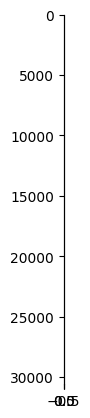

In [11]:
model = pixelModel()
# gauss = torchvision.transforms.GaussianBlur(3, sigma=(1, 1))

plt.imshow(model().detach())

In [12]:
# img = model()
# img = torch.permute(img, [1,0])
# img = torch.tile(img, dims=(3,1,1))
# img = gauss(img)[0]
# # img = torch.permute(img, [1,0])

# plt.imshow(img.detach())

/home/ab/anaconda3/envs/porous/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Running on CPU


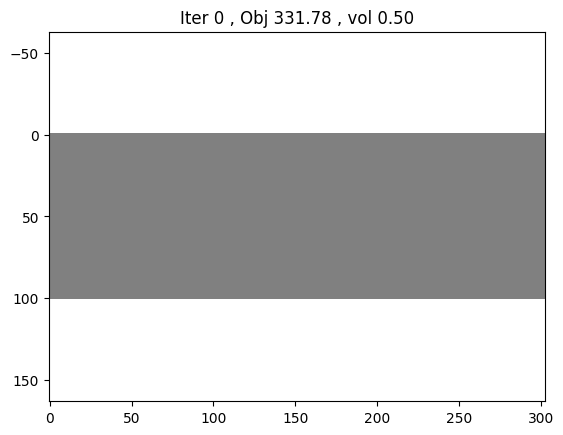

Iter 0 , Obj 331.78 , vol 0.50


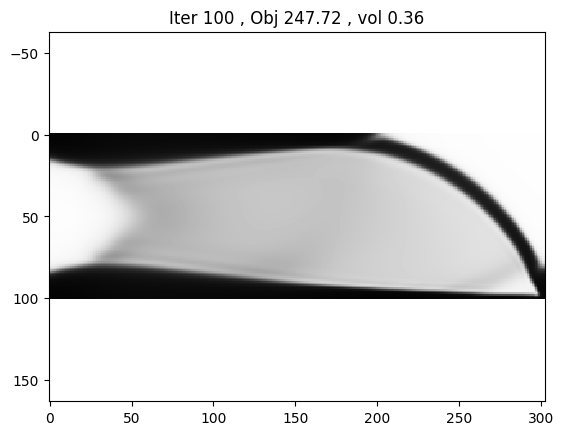

Iter 100 , Obj 247.72 , vol 0.36


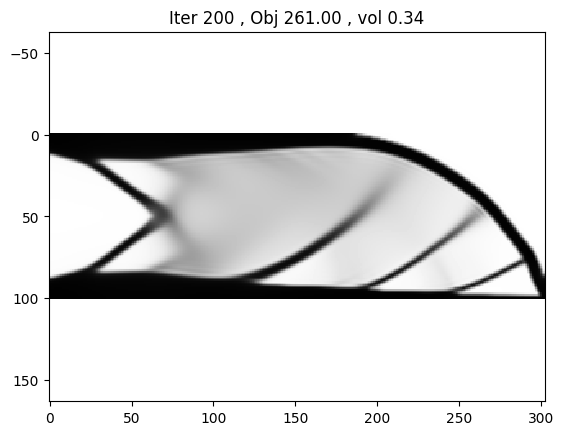

Iter 200 , Obj 261.00 , vol 0.34


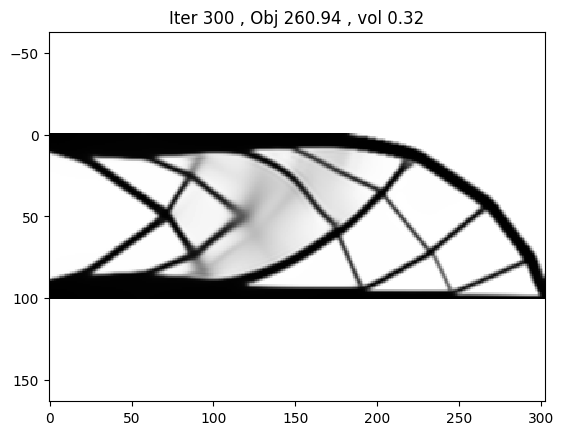

Iter 300 , Obj 260.94 , vol 0.32


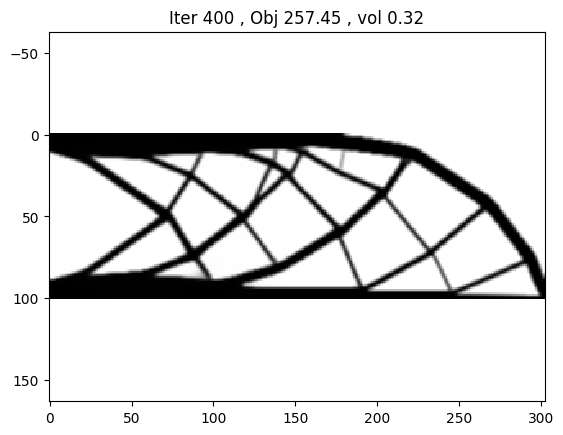

Iter 400 , Obj 257.45 , vol 0.32


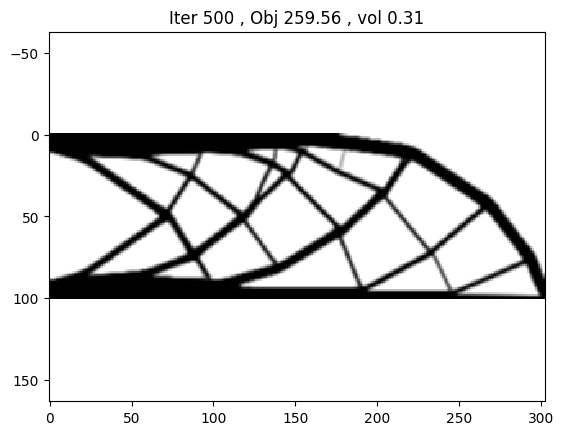

Iter 500 , Obj 259.56 , vol 0.31


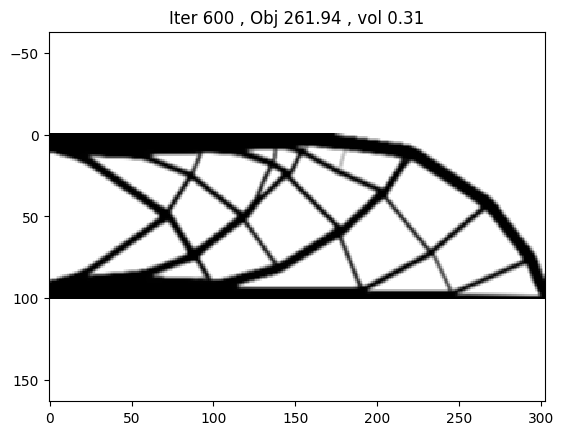

Iter 600 , Obj 261.94 , vol 0.31


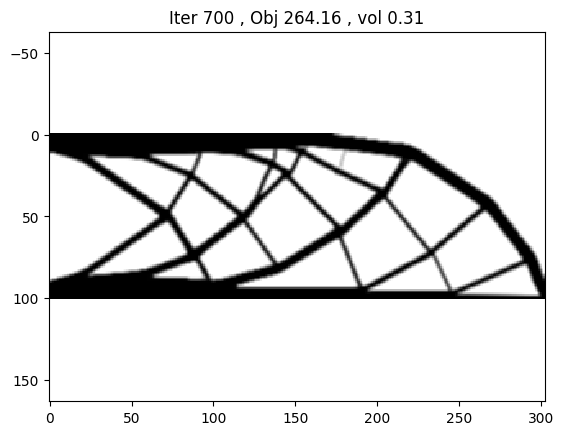

Iter 700 , Obj 264.16 , vol 0.31


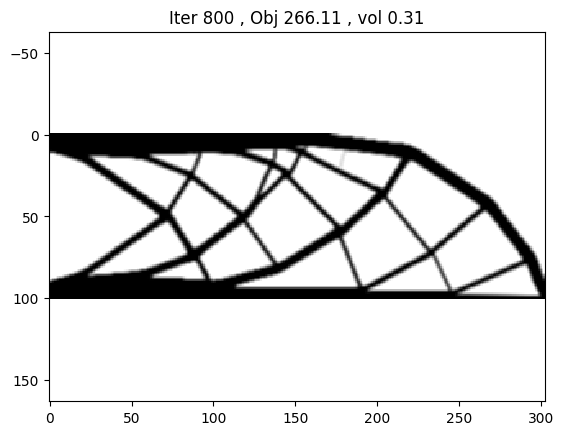

Iter 800 , Obj 266.11 , vol 0.31


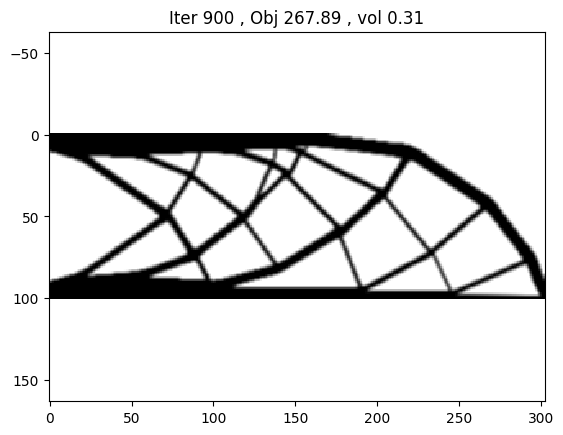

Iter 900 , Obj 267.89 , vol 0.31


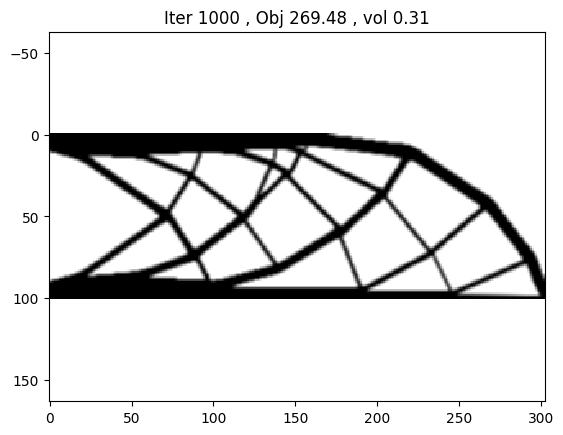

Iter 1000 , Obj 269.48 , vol 0.31


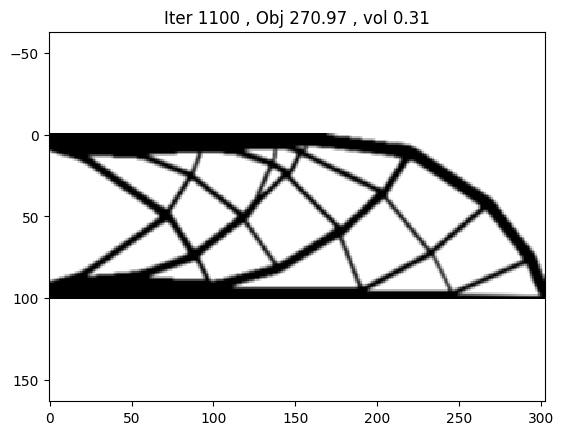

Iter 1100 , Obj 270.97 , vol 0.31


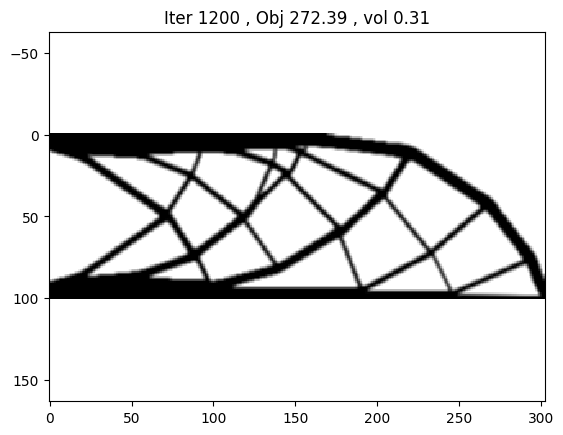

Iter 1200 , Obj 272.39 , vol 0.31


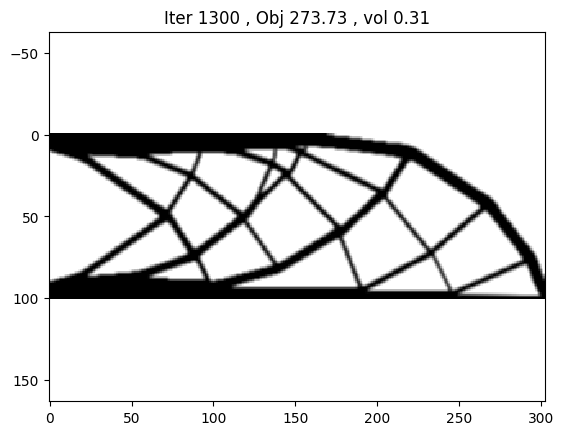

Iter 1300 , Obj 273.73 , vol 0.31


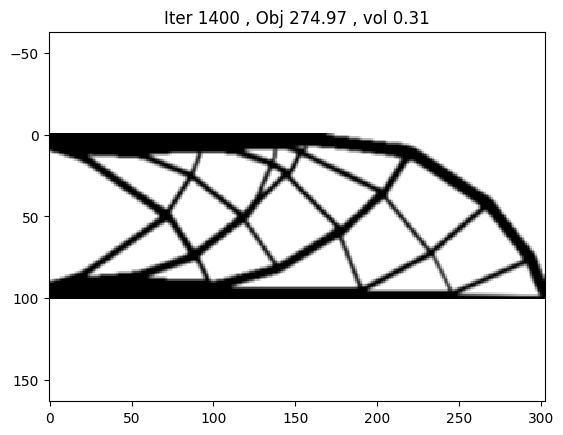

Iter 1400 , Obj 274.97 , vol 0.31


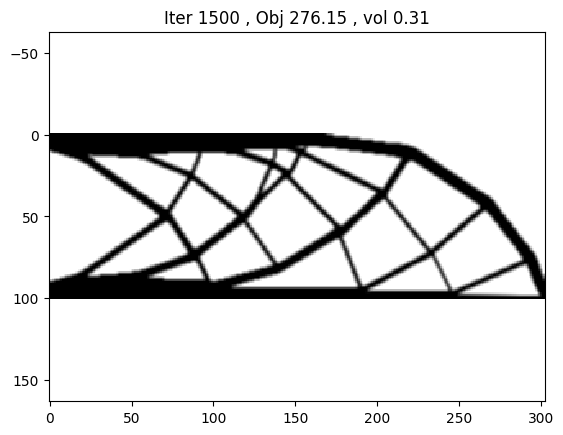

Iter 1500 , Obj 276.15 , vol 0.31


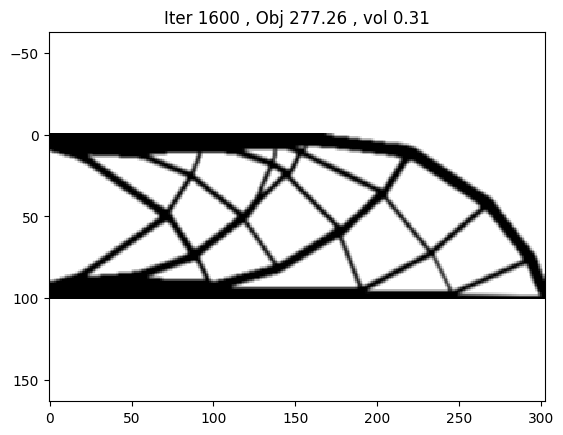

Iter 1600 , Obj 277.26 , vol 0.31


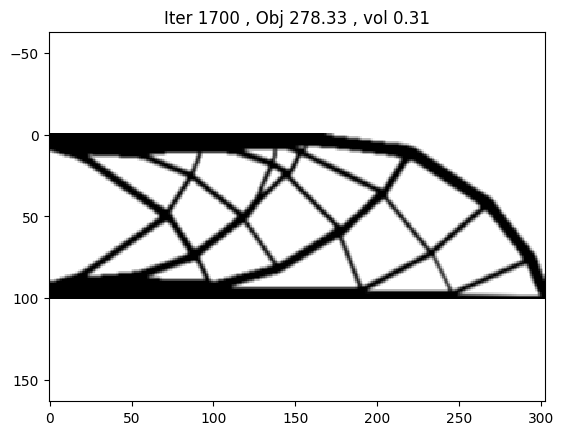

Iter 1700 , Obj 278.33 , vol 0.31


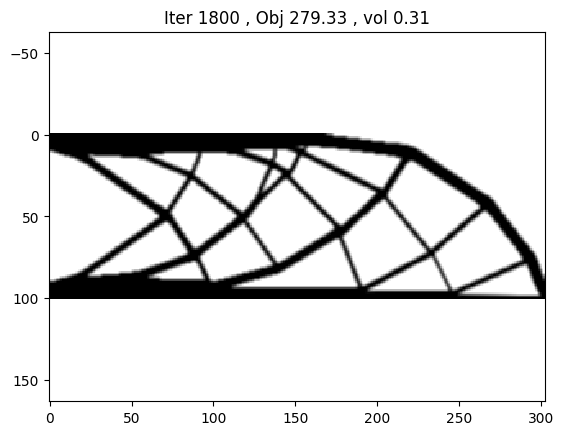

Iter 1800 , Obj 279.33 , vol 0.31


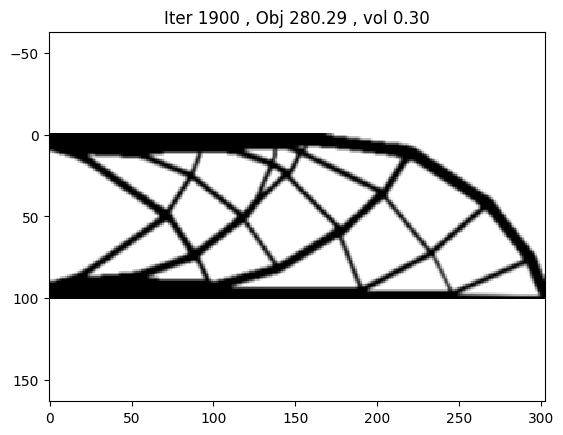

Iter 1900 , Obj 280.29 , vol 0.30


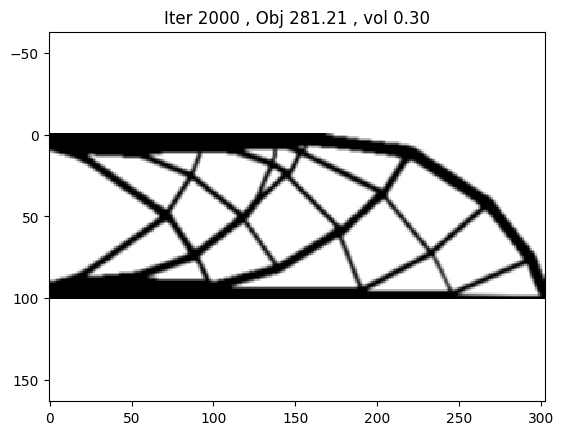

Iter 2000 , Obj 281.21 , vol 0.30


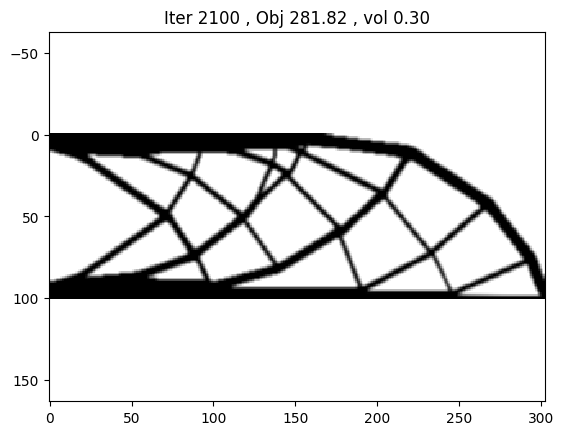

Iter 2100 , Obj 281.82 , vol 0.30


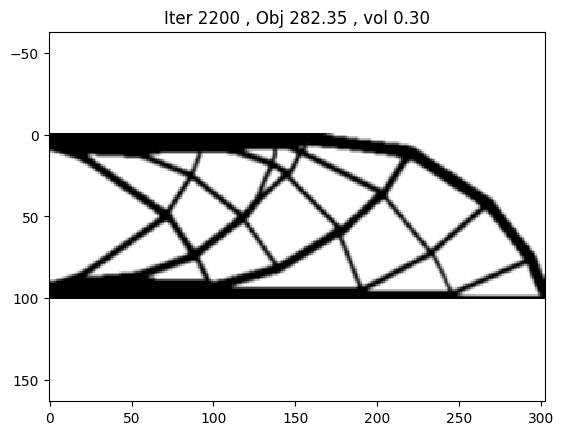

Iter 2200 , Obj 282.35 , vol 0.30


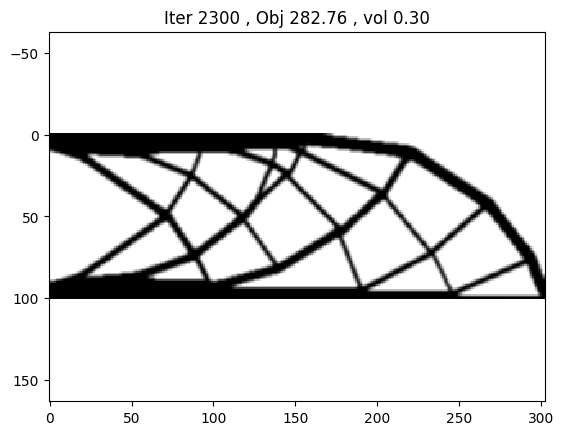

Iter 2300 , Obj 282.76 , vol 0.30


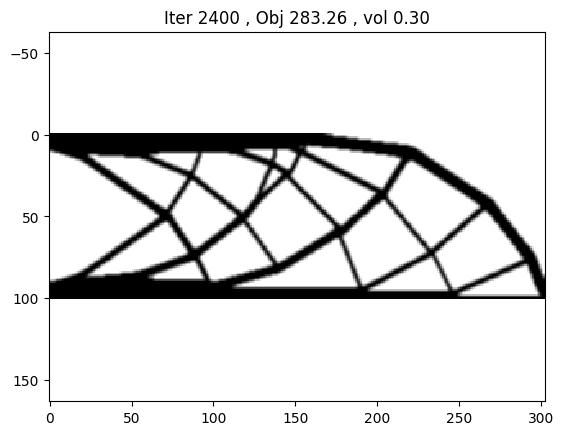

Iter 2400 , Obj 283.26 , vol 0.30


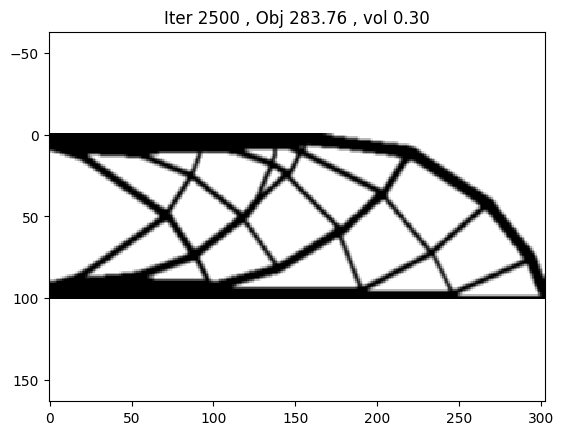

Iter 2500 , Obj 283.76 , vol 0.30


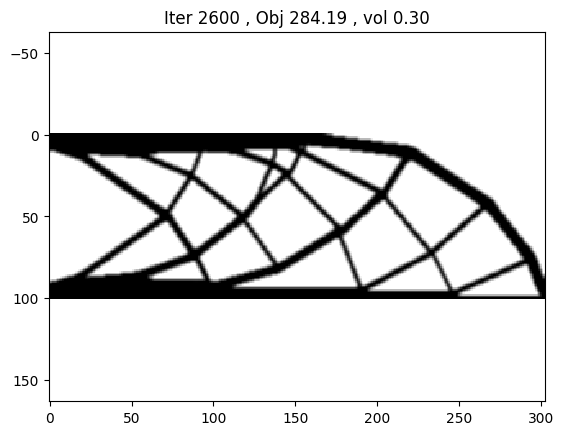

Iter 2600 , Obj 284.19 , vol 0.30


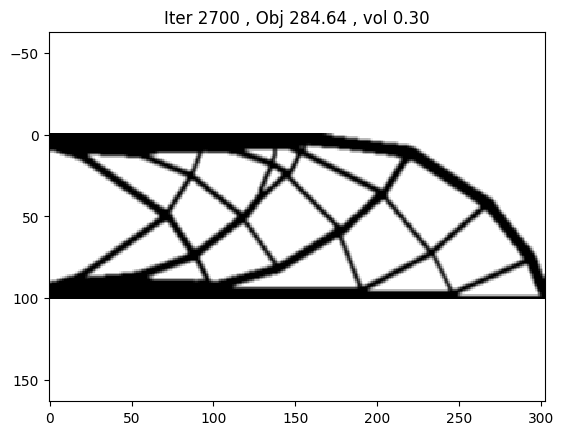

Iter 2700 , Obj 284.64 , vol 0.30


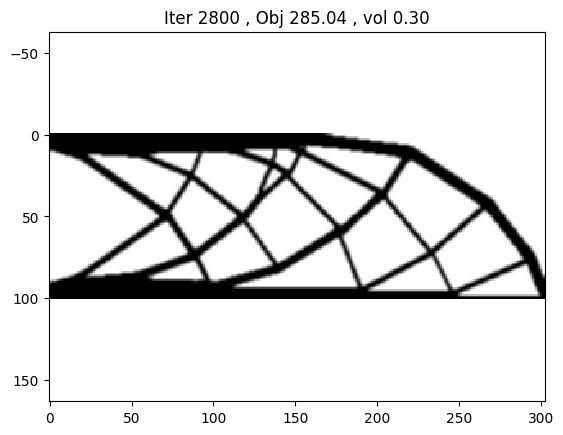

Iter 2800 , Obj 285.04 , vol 0.30


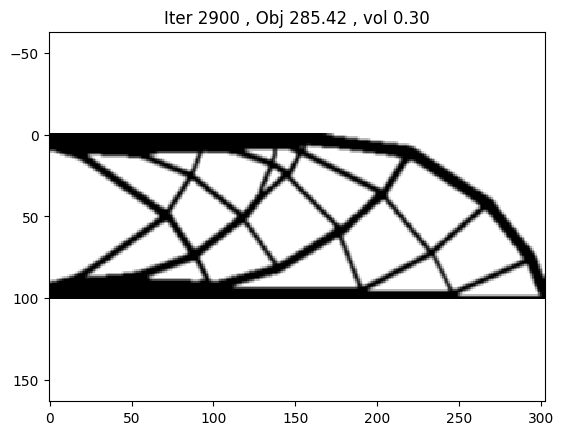

Iter 2900 , Obj 285.42 , vol 0.30


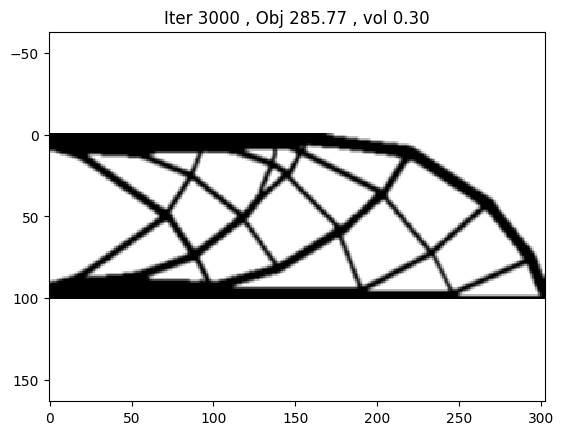

Iter 3000 , Obj 285.77 , vol 0.30


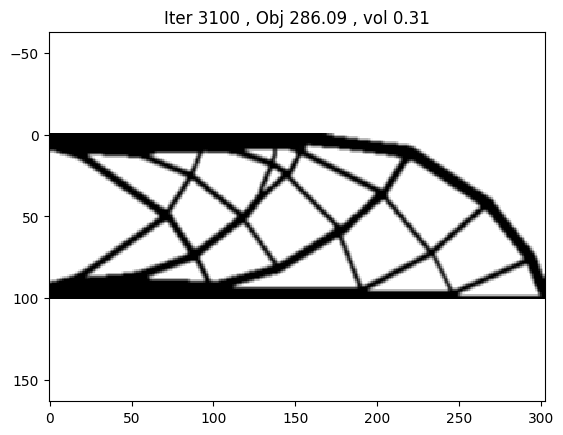

Iter 3100 , Obj 286.09 , vol 0.31


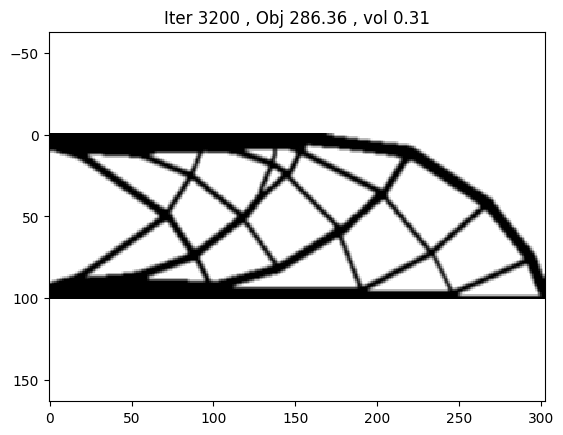

Iter 3200 , Obj 286.36 , vol 0.31


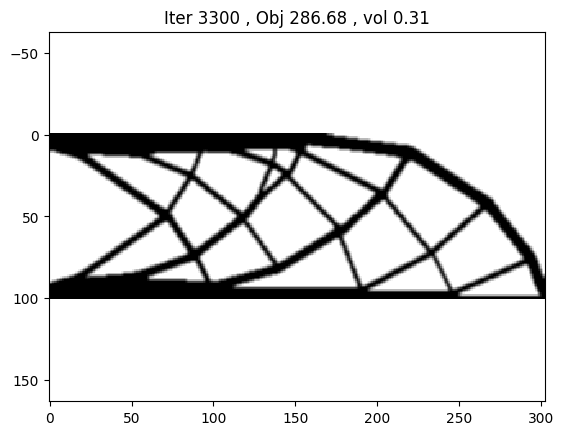

Iter 3300 , Obj 286.68 , vol 0.31


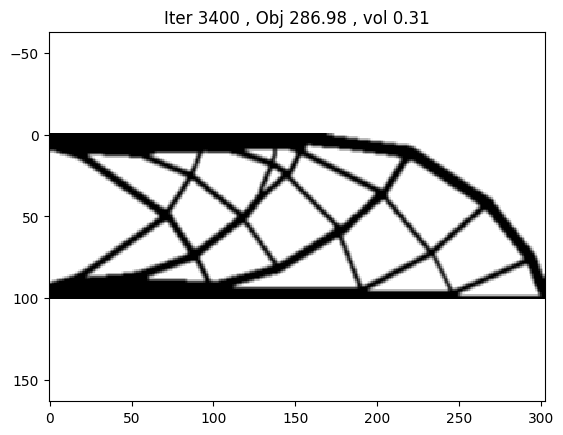

Iter 3400 , Obj 286.98 , vol 0.31


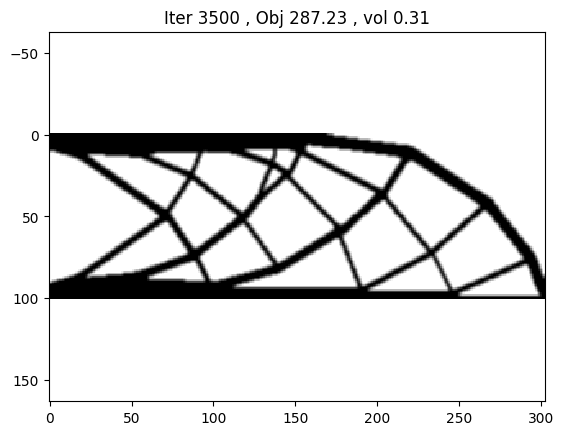

Iter 3500 , Obj 287.23 , vol 0.31


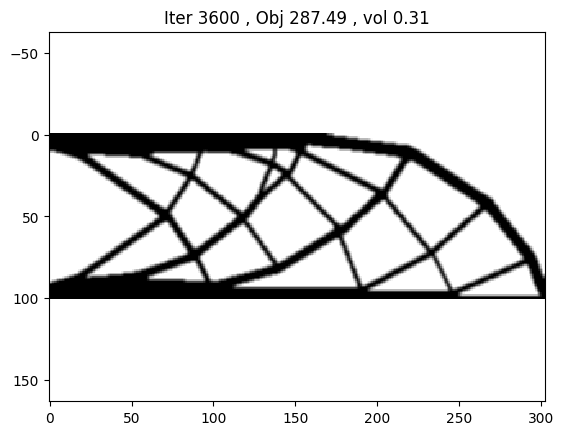

Iter 3600 , Obj 287.49 , vol 0.31


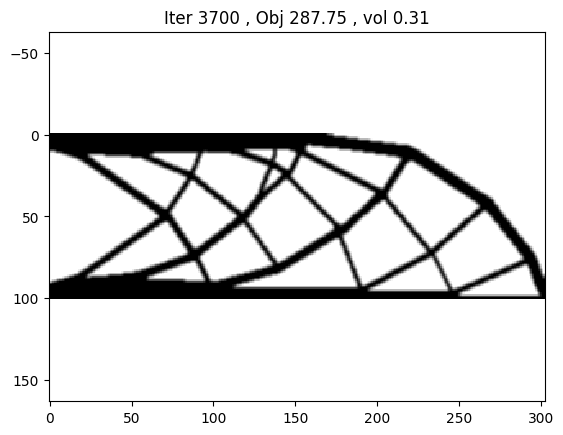

Iter 3700 , Obj 287.75 , vol 0.31


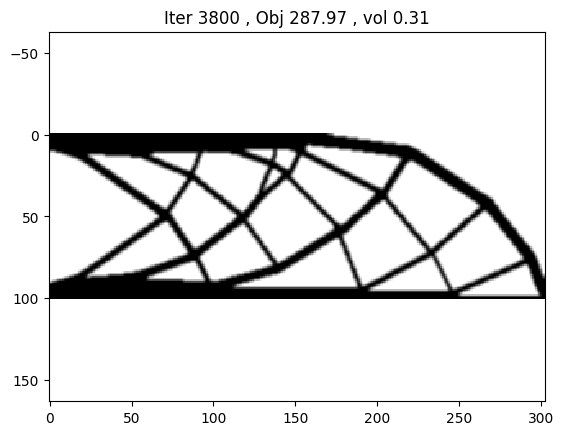

Iter 3800 , Obj 287.97 , vol 0.31


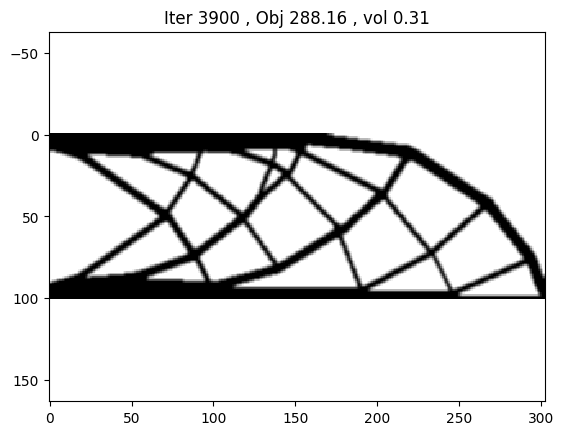

Iter 3900 , Obj 288.16 , vol 0.31


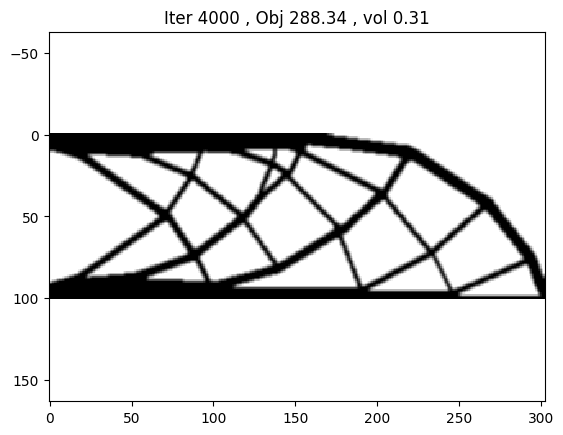

Iter 4000 , Obj 288.34 , vol 0.31


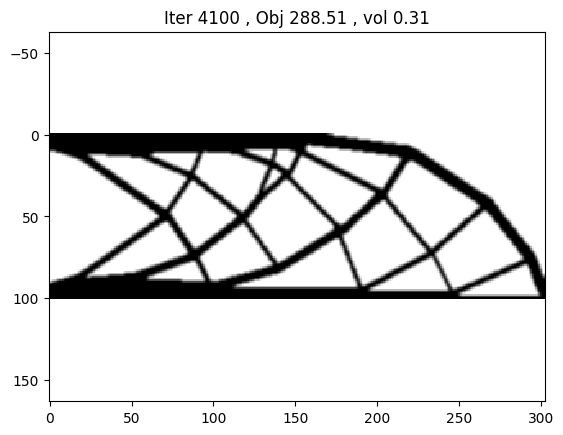

Iter 4100 , Obj 288.51 , vol 0.31


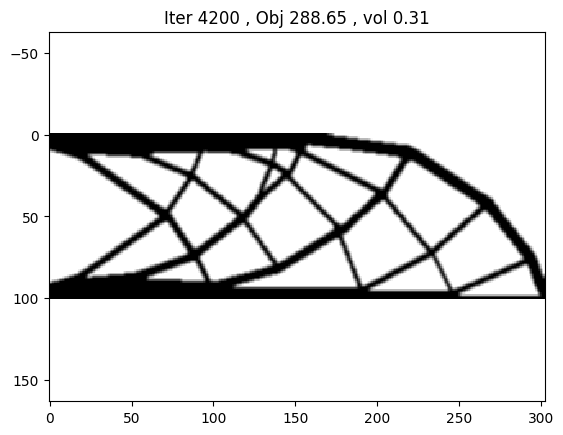

Iter 4200 , Obj 288.65 , vol 0.31


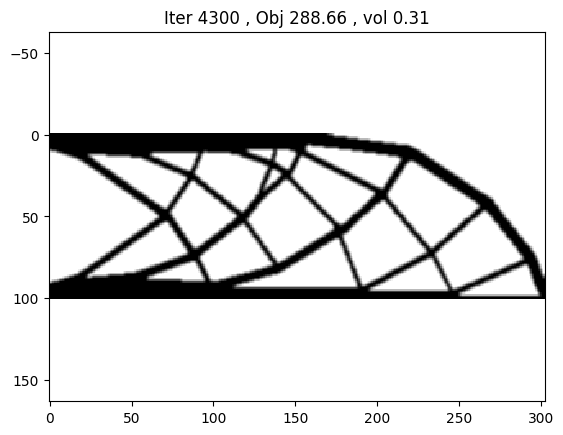

Iter 4300 , Obj 288.66 , vol 0.31


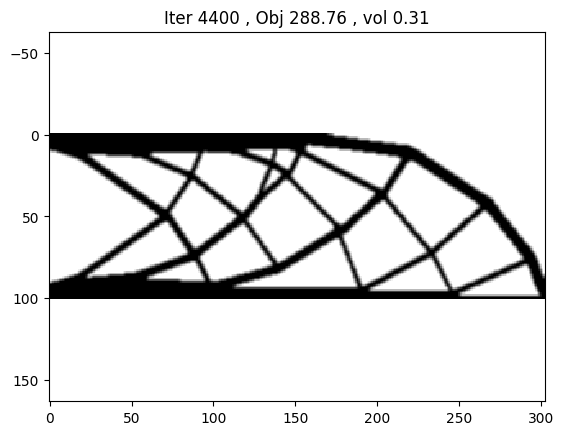

Iter 4400 , Obj 288.76 , vol 0.31


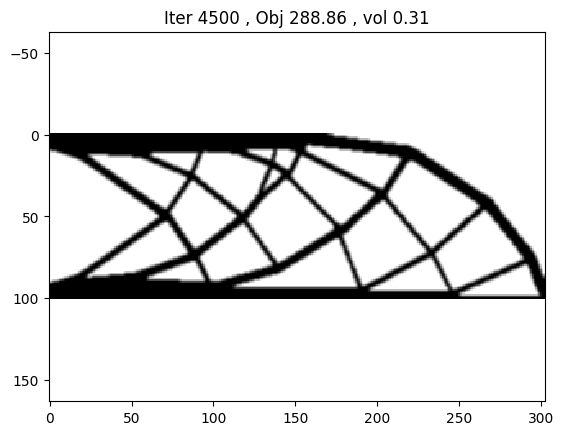

Iter 4500 , Obj 288.86 , vol 0.31


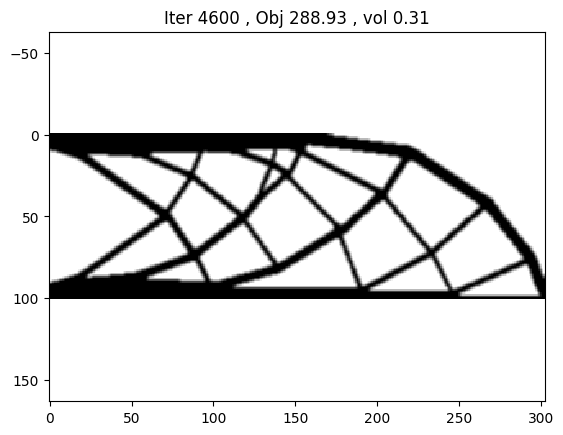

Iter 4600 , Obj 288.93 , vol 0.31


KeyboardInterrupt: 

In [13]:
model = pixelModel()

matProp = {'E':1.0, 'nu':0.3}; # Structural
matProp['penal'] = 1.5; # SIMP penalization constant, starting value

plt.close('all');
overrideGPU = False
start = time.perf_counter()
topOpt = TopologyOptimizer(mesh, matProp, bc, nnSettings, \
                  desiredVolumeFraction, densityProjection, overrideGPU);

topOpt.convergenceHistory = {'compliance':[], 'vol':[], 'grayElems':[]};
learningRate = 1e-1;
alphaMax = 100*topOpt.desiredVolumeFraction;
alphaIncrement = 0.015;
# alpha = alphaIncrement; # start
alpha = 0; # start
nrmThreshold = 0.05; # for gradient clipping
# topOpt.optimizer = optim.Adam(topOpt.topNet.parameters(), amsgrad=True, lr=learningRate);
topOpt.optimizer = optim.Adam(model.parameters(), amsgrad=True, lr=learningRate);


topOpt.obj0 = 385.11016982915766
# if(epoch == 0):
#     topOpt.obj0 = ( topOpt.FE.Emax*(rho_np**topOpt.FE.penal)*Jelem).sum()
# For sensitivity analysis, exponentiate by 2p here and divide by p in the loss func hence getting -ve sign

# nn_rho = torch.nn.Parameter(torch.zeros(size=(nelx, nely), requires_grad=True)).flatten()

for epoch in range(maxEpochs):
    topOpt.optimizer.zero_grad();

    # Parameters -> rho
    # x = topOpt.applySymmetry(topOpt.xy);
    # nn_rho = torch.flatten(topOpt.topNet(x)).to(topOpt.device);
    # nn_rho = topOpt.projectDensity(nn_rho);
    nn_rho = model().flatten()
    # print(nn_rho.shape)

    # Do the FEM-related computing
    rho_np = nn_rho.cpu().detach().numpy(); # move tensor to numpy array   
    topOpt.density = rho_np;
    u, Jelem = topOpt.FE.solve(rho_np); # Call FE 88 line code [Niels Aage 2013]
    Jelem1 = np.copy(Jelem)
    # print('one ', Jelem.shape)
    Jelem = np.array(topOpt.FE.Emax*(rho_np**(2*topOpt.FE.penal))*Jelem); #.reshape(-1);
    # print('two ', Jelem.shape)
    Jelem = torch.tensor(Jelem).float().to(topOpt.device);
    # print('three ', Jelem.shape)
    objective = torch.sum( Jelem / (nn_rho**topOpt.FE.penal))/topOpt.obj0; # compliance
    # break

    volConstraint = ((torch.mean(nn_rho)/topOpt.desiredVolumeFraction) - 1.0); # global vol constraint
    currentVolumeFraction = np.average(rho_np);
    topOpt.objective = objective;
    loss = topOpt.objective + alpha * torch.pow(volConstraint, 2);

    alpha = min(alphaMax, alpha + alphaIncrement);
    loss.backward(retain_graph=True);
    # torch.nn.utils.clip_grad_norm_(topOpt.topNet.parameters(), nrmThreshold)
    topOpt.optimizer.step();

    greyElements = sum(1 for rho in rho_np if ((rho > 0.05) & (rho < 0.95)));
    relGreyElements = topOpt.desiredVolumeFraction * greyElements / len(rho_np);
    topOpt.convergenceHistory['compliance'].append(topOpt.objective.item());
    topOpt.convergenceHistory['vol'].append(currentVolumeFraction);
    topOpt.convergenceHistory['grayElems'].append(relGreyElements);
    topOpt.FE.penal = min(8.0,topOpt.FE.penal + 1.0/1000); # continuation scheme

    if(epoch % 100 == 0):
        titleStr = "Iter {:d} , Obj {:.2F} , vol {:.2F}".format(epoch, topOpt.objective.item()*topOpt.obj0, currentVolumeFraction);
        topOpt.Pltr.plotDensity(topOpt.xy.detach().cpu().numpy(), rho_np.reshape((topOpt.FE.nelx, topOpt.FE.nely)), titleStr);
        print(titleStr);
    if ((epoch > minEpochs ) & (relGreyElements < 0.01)):
        break;

# topOpt.Pltr.plotDensity(topOpt.xy.detach().cpu().numpy(), rho_np.reshape((topOpt.FE.nelx, topOpt.FE.nely)), titleStr);
# print("{:3d} J: {:.2F}; Vf: {:.3F}; loss: {:.3F}; relGreyElems: {:.3F} "\
#         .format(epoch, topOpt.objective.item()*topOpt.obj0, currentVolumeFraction, loss.item(), relGreyElements));

# print("Final J : {:.3f}".format(topOpt.objective.item()*topOpt.obj0));
# topOpt.Pltr.plotConvergence(topOpt.convergenceHistory);

# x = topOpt.applySymmetry(topOpt.xyPlot);
# rho = torch.flatten(topOpt.projectDensity(topOpt.topNet(x)));
# rho_np = rho.cpu().detach().numpy();

# titleStr = "Iter {:d} , Obj {:.2F} , vol {:.2F}".format(epoch, topOpt.objective.item()*topOpt.obj0, currentVolumeFraction);
# topOpt.Pltr.plotDensity(topOpt.xyPlot.detach().cpu().numpy(), rho_np.reshape((topOpt.FE.nelx*topOpt.boundaryResolution, topOpt.FE.nely*topOpt.boundaryResolution)), titleStr);

In [ ]:
def unfuck(flat_img):
    img2d = img.reshape(nelx, nely)
    return img2d

def refuck(img2d):
    return img2d.reshape(1,-1).T
    
a = unfuck(model()).detach()

# torch.allclose(a2,b)

In [ ]:
a

In [ ]:
plt.imshow(a)

In [ ]:
plt.imshow(rho_np.reshape(nely, nelx))

In [ ]:
plt.imshow(Jelem1.reshape(nely, nelx))

In [ ]:
# x = topOpt.applySymmetry(topOpt.xy);
# nn_rho = torch.flatten(topOpt.topNet(x)).to(topOpt.device);
# nn_rho = topOpt.projectDensity(nn_rho);

# # Do the FEM-related computing
# rho_np = nn_rho.cpu().detach().numpy(); # move tensor to numpy array   
# plt.imshow(rho_np.reshape((topOpt.FE.nelx, topOpt.FE.nely)).T)
# plt.colorbar()